In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from os import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

SyntaxError: invalid syntax (3560908997.py, line 1)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

##1) Create Image_File DataFrame

In [ ]:
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/dataset/2nd_snack')
filepaths = list(dir_.glob(r'**/*.jpg'))

def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/dataset...,oreo
1,/content/drive/MyDrive/Colab Notebooks/dataset...,shrimp
2,/content/drive/MyDrive/Colab Notebooks/dataset...,shrimp
3,/content/drive/MyDrive/Colab Notebooks/dataset...,chip
4,/content/drive/MyDrive/Colab Notebooks/dataset...,pizza


##2) Data EDA

In [ ]:
print('The number of pictures:', df.shape[0])
print('The number of snacks:', len(df.Label.unique()))
print('Labels:', df.Label.unique())

The number of pictures: 2500
The number of snacks: 10
Labels: ['oreo' 'shrimp' 'chip' 'pizza' 'heim' 'pepero' 'turtle' 'pie' 'banana'
 'onion']


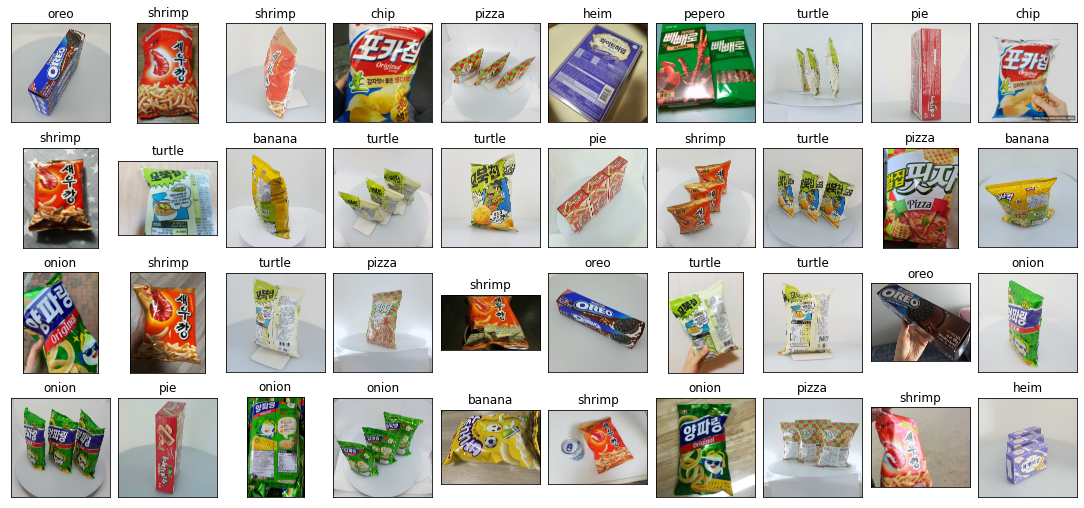

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

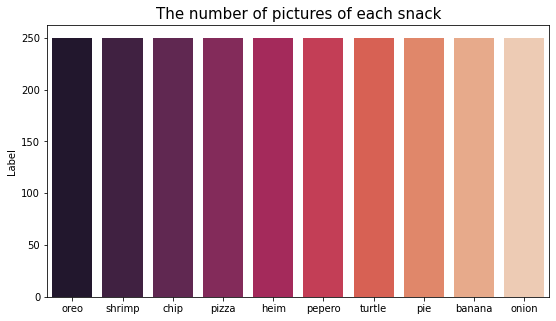

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("The number of pictures of each snack", fontsize = 15)
plt.show()

##3) Train / Test Split

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((2250, 2), (250, 2))

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=0)
train_df.shape, valid_df.shape

((2025, 2), (225, 2))

##4) ImageDataGenerator( ) & flow_from_dataframe( )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.)
valid_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(75, 75),
                                                    batch_size=16,
                                                    class_mode='categorical'
                                                    )

valid_generator  = valid_datagen.flow_from_dataframe(valid_df,
                                                     x_col='Filepath',
                                                     y_col='Label',
                                                     target_size=(75, 75),
                                                     batch_size=16,
                                                     class_mode='categorical'
                                                     )

Found 2025 validated image filenames belonging to 10 classes.
Found 225 validated image filenames belonging to 10 classes.


##5) Test train_generator

In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (16, 75, 75, 3)
배치 레이블 크기: (16, 10)


In [ ]:
labels_batch

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

##6) Data Augmentation

In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(75, 75), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=10,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(75, 75),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=16,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(75, 75),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=16,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

##7) CNN Modeling(Base Model)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (75, 75, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

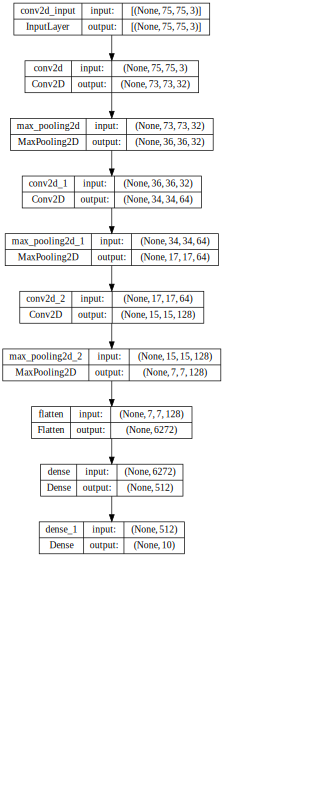

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

dot_res = model_to_dot(model,show_shapes=True, dpi=50).create(prog='dot', format='svg')
fi = open("model_cnn_1.svg", 'wb')
fi.write(dot_res)
fi.close()

SVG(dot_res)

- 모델 학습방법 설정

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 127,
                       epochs = 10,
                       validation_data = valid_generator,
                       validation_steps = 8)

Epoch 1/10
127/127 [==============================] - 665s 5s/step - loss: 1.2876 - accuracy: 0.4978 - val_loss: 0.6272 - val_accuracy: 0.7422
Epoch 2/10
127/127 [==============================] - 169s 1s/step - loss: 0.4602 - accuracy: 0.8395 - val_loss: 0.4515 - val_accuracy: 0.8594
Epoch 3/10
127/127 [==============================] - 159s 1s/step - loss: 0.2352 - accuracy: 0.9200 - val_loss: 0.1343 - val_accuracy: 0.9453
Epoch 4/10
127/127 [==============================] - 153s 1s/step - loss: 0.1276 - accuracy: 0.9565 - val_loss: 0.1332 - val_accuracy: 0.9531
Epoch 5/10
127/127 [==============================] - 155s 1s/step - loss: 0.0645 - accuracy: 0.9793 - val_loss: 0.2965 - val_accuracy: 0.8984
Epoch 6/10
127/127 [==============================] - 156s 1s/step - loss: 0.0998 - accuracy: 0.9719 - val_loss: 0.1924 - val_accuracy: 0.9375
Epoch 7/10
127/127 [==============================] - 156s 1s/step - loss: 0.0526 - accuracy: 0.9817 - val_loss: 0.0607 - val_accuracy: 0.9766

-  Loss Visualization

In [ ]:
print(Hist_dandc.history['val_loss'])
print(Hist_dandc.history['loss'])

[0.6272463798522949, 0.45145323872566223, 0.13427206873893738, 0.13317054510116577, 0.296521931886673, 0.19241313636302948, 0.06074909865856171, 0.27386289834976196, 0.22862860560417175, 0.11381080001592636]
[1.2875945568084717, 0.4602319002151489, 0.23517277836799622, 0.12761177122592926, 0.06447150558233261, 0.09981267154216766, 0.05264978110790253, 0.017262203618884087, 0.009621413424611092, 0.09178181737661362]


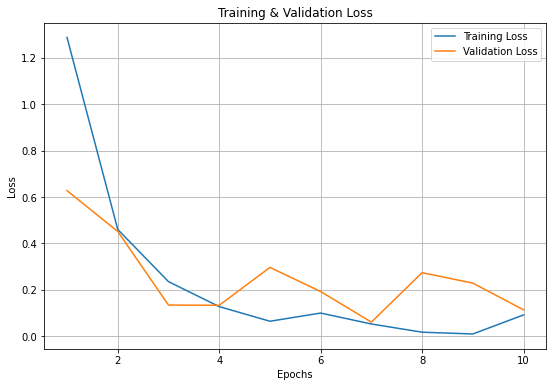

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

- Accuracy Visualization

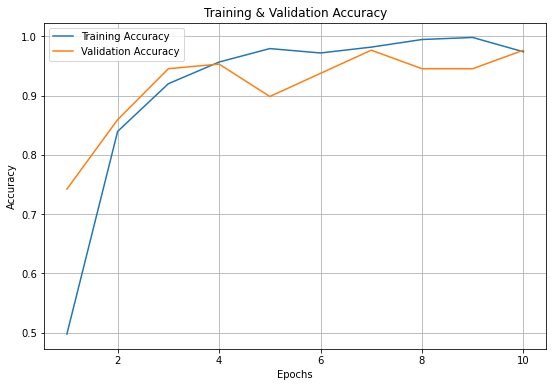

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

##8) Model Evaluate(Base Model)

- test_generator

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(75, 75),
                                                  batch_size=16)

NameError: ignored

In [ ]:
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

##9) 전이학습 모델 도입을 통해 성능 높이기

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(75, 75, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 10으로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1823 validated image filenames belonging to 10 classes.
Found 202 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


29084464/29084464 [==============================] - 0s 0us/step


DenseNet121          trained in 153.88 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 144.19 sec
74836368/74836368 [==============================] - 1s 0us/step
DenseNet201          trained in 157.27 sec
16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 148.66 sec
27018416/27018416 [==============================] - 1s 0us/step
EfficientNetB1       trained in 152.76 sec
87910968/87910968 [==============================] - 2s 0us/step


InceptionV3          trained in 148.68 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 147.69 sec
234545216/234545216 [==============================] - 12s 0us/step
ResNet152V2          trained in 155.99 sec
94765736/94765736 [==============================] - 2s 0us/step
ResNet50             trained in 145.79 sec
94668760/94668760 [==============================] - 2s 0us/step
ResNet50V2           trained in 141.41 sec
80134624/80134624 [==============================] - 0s 0us/step
VGG19                trained in 140.44 sec
58889256/58889256 [==============================] - 0s 0us/step
VGG16                trained in 140.69 sec
83683744/83683744 [==============================] - 1s 0us/step
Xception             trained in 144.82 sec


In [ ]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

16/16 [==============================] - 21s 1s/step
**DenseNet121 has a 90.80% accuracy on the test set**
16/16 [==============================] - 19s 1s/step
**MobileNetV2 has a 86.40% accuracy on the test set**
16/16 [==============================] - 21s 1s/step
**DenseNet201 has a 92.80% accuracy on the test set**
16/16 [==============================] - 20s 1s/step
**EfficientNetB0 has a 9.20% accuracy on the test set**
16/16 [==============================] - 20s 1s/step
**EfficientNetB1 has a 11.20% accuracy on the test set**
16/16 [==============================] - 19s 1s/step
**InceptionV3 has a 54.00% accuracy on the test set**
16/16 [==============================] - 19s 1s/step
**MobileNetV3Large has a 12.00% accuracy on the test set**
16/16 [==============================] - 21s 1s/step
**ResNet152V2 has a 70.80% accuracy on the test set**
16/16 [==============================] - 19s 1s/step
**ResNet50 has a 23.20% accuracy on the test set**
16/16 [=======================

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9356,0.928,157.27
1,DenseNet121,0.9307,0.908,153.88
2,MobileNetV2,0.8861,0.864,144.19
3,VGG16,0.7574,0.780,140.69
4,Xception,0.7376,0.756,144.82
5,ResNet152V2,0.7327,0.708,155.99
6,ResNet50V2,0.7129,0.692,141.41
7,VGG19,0.6683,0.612,140.44
8,InceptionV3,0.6089,0.540,148.68
9,ResNet50,0.1881,0.232,145.79


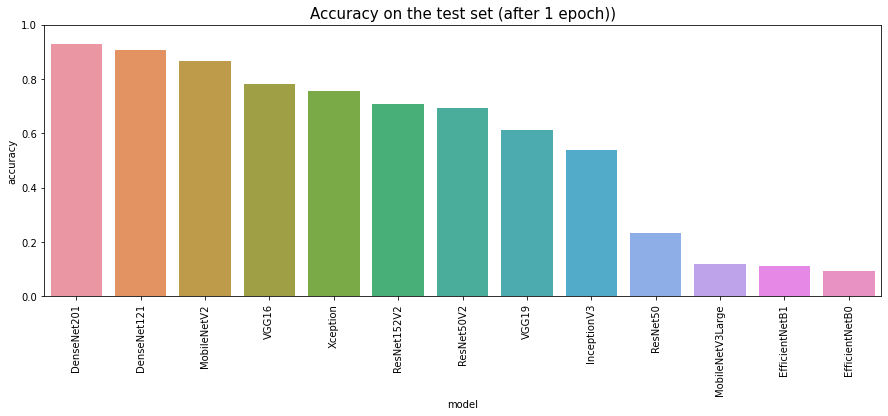

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

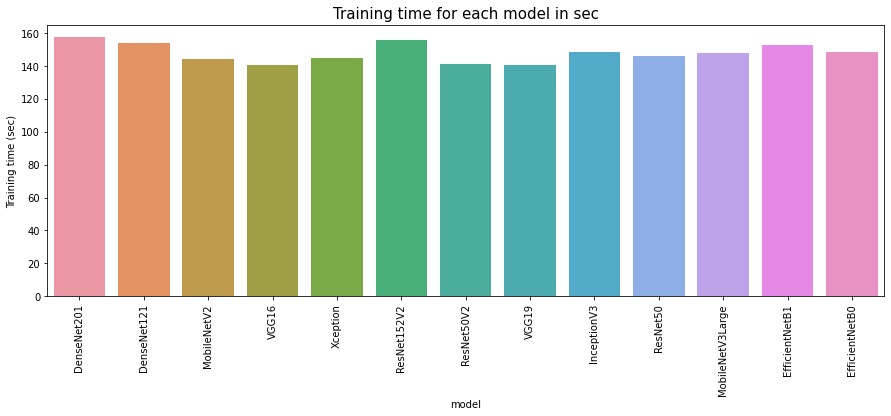

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 2025 validated image filenames belonging to 10 classes.
Found 225 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
Epoch 1/7
203/203 [==============================] - 172s 797ms/step - loss: 0.6116 - accuracy: 0.7975 - val_loss: 0.1665 - val_accuracy: 0.9556
Epoch 2/7
203/203 [==============================] - 151s 746ms/step - loss: 0.0874 - accuracy: 0.9709 - val_loss: 0.1236 - val_accuracy: 0.9600
Epoch 3/7
203/203 [==============================] - 150s 735ms/step - loss: 0.0145 - accuracy: 0.9980 - val_loss: 0.0779 - val_accuracy: 0.9778
Epoch 4/7
203/203 [==============================] - 149s 733ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0541 - val_accuracy: 0.9822
Epoch 5/7
203/203 [==============================] - 149s 733ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9867
Epoch 6/7
203/203 [==============================] - 148s 731ms/step - loss: 9.1036e-04 - a

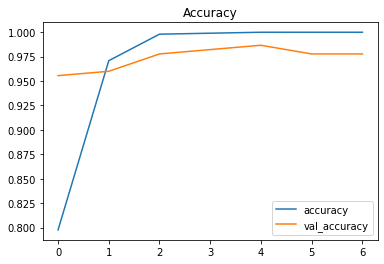

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

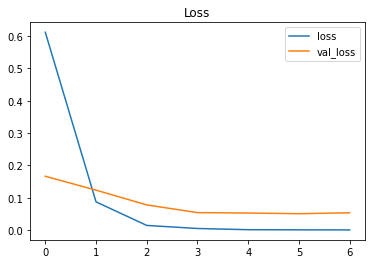

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

16/16 [==============================] - 20s 1s/step
Accuracy on the test set: 97.60%


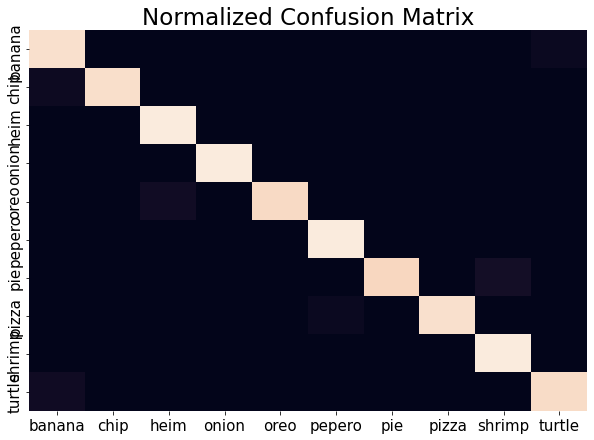

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()